In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ip = "52.233.29.106"
duckdb.sql("INSTALL postgres;")
duckdb.sql("LOAD postgres;")
duckdb.sql(f"ATTACH 'dbname=postgres user=postgres host={ip} password=template!PWD' AS db (TYPE POSTGRES);")


In [3]:
#from db.database import Database
#Database.clear()

In [13]:
duckdb.query("""
SELECT * FROM db.public.compute_configs
""")

┌──────────────────────────────────────┬────────────────────────────────┬────────────────────────┐
│                run_id                │       team_distribution        │      batch_sizes       │
│                 uuid                 │            varchar             │        varchar         │
├──────────────────────────────────────┼────────────────────────────────┼────────────────────────┤
│ dbf75cc8-bc45-4ebc-9820-60c9d451100e │ [("alice", 180), ("bob", 180)] │ {"alice": 6, "bob": 6} │
└──────────────────────────────────────┴────────────────────────────────┴────────────────────────┘

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

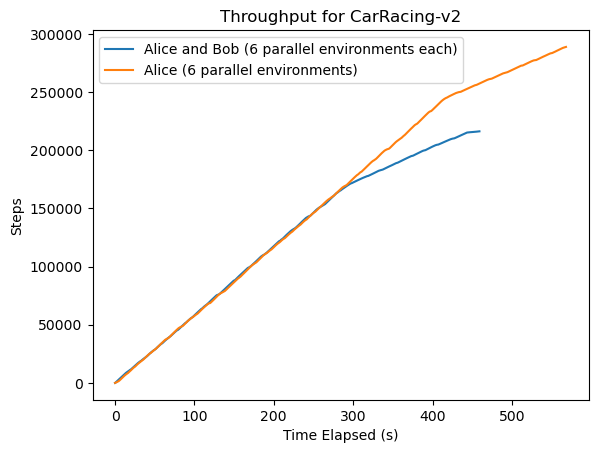

In [5]:
df_2_workers = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = 'dbf75cc8-bc45-4ebc-9820-60c9d451100e'
ORDER BY time
""").df()

df_1_worker = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = '55bd1329-7f36-4a1c-88fd-3d2d8a3fc80b'
ORDER BY time
""").df()

for df in [df_2_workers, df_1_worker]:
    df['elapsed_time'] = df['time'] - df['time'].min()


plt.plot(df_2_workers['elapsed_time'], df_2_workers['num_steps'], label='Alice and Bob (6 parallel environments each)')
plt.plot(df_1_worker['elapsed_time'], df_1_worker['num_steps'], label='Alice (6 parallel environments)')

plt.ylabel('Steps')
plt.xlabel('Time Elapsed (s)')
plt.title("Throughput for CarRacing-v2")
plt.legend()

In [23]:
duckdb.query("""
SELECT * FROM db.public.training
WHERE run_id = 'dbf75cc8-bc45-4ebc-9820-60c9d451100e'
ORDER BY time DESC
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────┬────────────┬──────────────────────┬─────────────┬───┬───────────┬────────────────────┬────────┐
│        run_id        │ generation │       team_id        │ is_finished │ … │ time_step │        time        │ action │
│         uuid         │   int32    │         uuid         │   boolean   │   │   int32   │       double       │ int32  │
├──────────────────────┼────────────┼──────────────────────┼─────────────┼───┼───────────┼────────────────────┼────────┤
│ dbf75cc8-bc45-4ebc…  │          1 │ b804a6f0-539c-45da…  │ false       │ … │       923 │  1723296208.458326 │      0 │
│ dbf75cc8-bc45-4ebc…  │          1 │ b804a6f0-539c-45da…  │ false       │ … │       922 │ 1723296208.4484298 │      0 │
│ dbf75cc8-bc45-4ebc…  │          1 │ b804a6f0-539c-45da…  │ false       │ … │       921 │  1723296208.437927 │      0 │
│ dbf75cc8-bc45-4ebc…  │          1 │ b804a6f0-539c-45da…  │ false       │ … │       920 │ 1723296208.4276624 │      0 │
│ dbf75cc8-bc45-4ebc…  │        

IndexError: index 0 is out of bounds for axis 0 with size 0

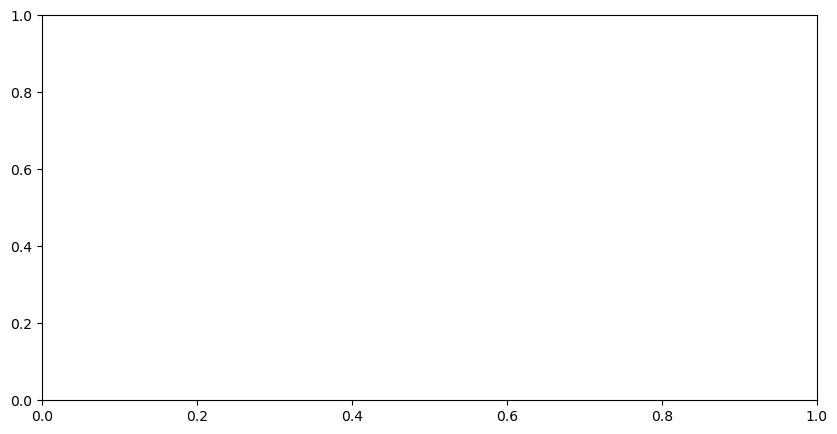

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from scipy.ndimage import gaussian_filter1d

# Define the workers you want to plot
workers = ['alice', 'bob']

# Define smoothing function
def smooth_data(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# Plotting for each worker
for worker in workers:
    # Query and prepare the data
    df = duckdb.query(f"""
    SELECT * FROM db.public.cpu_utilization
    WHERE worker = '{worker}'
    AND run_id = 'ea9c34f6-005f-4a7d-9607-ef9baae31a3f'
    """).df()

    # Calculate time elapsed
    df['time_elapsed'] = df['time'] - df['time'].min()

    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(index='time_elapsed', columns='core', values='utilization', aggfunc='mean')

    # Smooth the data
    window_size = 5  # Adjust window size as needed
    smoothed_df = pivot_df.apply(lambda x: smooth_data(pd.Series(x), window_size))

    # Create a new figure for each worker
    plt.figure(figsize=(10, 5))

    # Plotting
    plt.stackplot(smoothed_df.index, smoothed_df.T, labels=smoothed_df.columns, alpha=0.7)

    
    # Set title based on worker type
    if worker == "alice":
        plt.title(f'CPU Utilization vs Time (Alice)')
    elif worker == "bob":
        plt.title(f'CPU Utilization vs Time (Bob)')

    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Core Utilization (%)')
    plt.ylim(0, 1200)
    plt.legend(title='Core')

    plt.show()
    # Save the figure
    plt.savefig(f"./figures/cpu_utilization_{worker}.png")
    
    # Close the figure
    plt.close()
